In [1]:
import os
os.environ['KERAS_BACKEND']='theano'

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

import pandas as pd
import datetime
import seaborn as sns
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequen ce (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
x=datetime.datetime.now()
df1=pd.read_csv("../data/Data_Energy/energydata_complete.csv",header=0, index_col=0)
cols=['rv1','rv2','Visibility','T9','T_out','T1','T7','T5','Tdewpoint','Windspeed','RH_9','RH_4','T6','RH_7']
df1.drop(cols, axis=1, inplace=True)
# df1=df1[['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4','RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9','RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility','Tdewpoint', 'rv1', 'rv2','Appliances']]
#phase1(0.01-0.02): 'rv1','rv2','Visibility','T9'
#phase2(0.02-0.03): 'T_out','T1','T7','T5','Tdewpoint','Windspeed','RH_9','RH_4','T6','RH_7'

values = df1.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
reframed = series_to_supervised(values, 1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [6]:
# split into train and test sets
values = reframed
n_train_hours =int(0.8*df1.shape[0])
train = values[(len(df1.columns)):n_train_hours, :]
test = values[n_train_hours:, :]
#print(train)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(15774, 1, 27) (15774,) (3946, 1, 27) (3946,)


Train on 15774 samples, validate on 3946 samples
Epoch 1/20
 - 138s - loss: 0.4885 - val_loss: 0.2015
Epoch 2/20
 - 143s - loss: 0.1709 - val_loss: 0.1852
Epoch 3/20
 - 141s - loss: 0.1443 - val_loss: 0.1841
Epoch 4/20
 - 145s - loss: 0.1288 - val_loss: 0.1448
Epoch 5/20
 - 152s - loss: 0.1195 - val_loss: 0.1273
Epoch 6/20
 - 143s - loss: 0.1129 - val_loss: 0.1098
Epoch 7/20
 - 141s - loss: 0.1093 - val_loss: 0.0986
Epoch 8/20
 - 141s - loss: 0.1052 - val_loss: 0.0914
Epoch 9/20
 - 140s - loss: 0.1000 - val_loss: 0.0868
Epoch 10/20
 - 140s - loss: 0.0951 - val_loss: 0.0827
Epoch 11/20
 - 146s - loss: 0.0928 - val_loss: 0.0792
Epoch 12/20
 - 136s - loss: 0.0914 - val_loss: 0.0761
Epoch 13/20
 - 138s - loss: 0.0911 - val_loss: 0.0762
Epoch 14/20
 - 149s - loss: 0.0927 - val_loss: 0.0810
Epoch 15/20
 - 140s - loss: 0.0960 - val_loss: 0.0921
Epoch 16/20
 - 150s - loss: 0.1001 - val_loss: 0.1027
Epoch 17/20
 - 143s - loss: 0.0963 - val_loss: 0.0981
Epoch 18/20
 - 141s - loss: 0.0880 - val_l

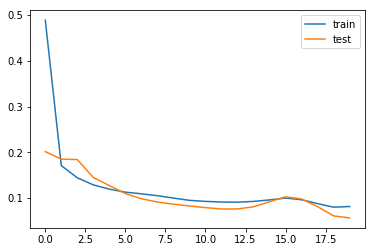

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(20))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=1000, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [8]:
# make a prediction
yhat_test = model.predict(test_X)
yhat_train = model.predict(train_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

In [9]:
# invert scaling for forecast
inv_yhat_test = concatenate((yhat_test, test_X), axis=1)
inv_yhat_train = concatenate((yhat_train,train_X),axis=1)
print(inv_yhat_test.shape)
print(inv_yhat_train.shape)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_test = concatenate((test_y, test_X[:,:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]

train_y = train_y.reshape((len(train_y), 1))
inv_y_train = concatenate((train_y, train_X[:,:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]


(3946, 28)
(15774, 28)


In [10]:
# calculate RMSE
rmse_test = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
rmse_train = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
print('Test RMSE: ',rmse_test)
print('Train RMSE: ',rmse_train)

errors_test=abs(inv_yhat_test-inv_y_test)
errors_train=abs(inv_yhat_train-inv_y_train)
print('Mean Absolute Error test data:', round(np.mean(errors_test), 2), 'Wh')
print('Mean Absolute Error train data:', round(np.mean(errors_train), 2), 'Wh')


mape_test = 100 * (errors_test / inv_y_test)
mape_train = 100 * (errors_train / inv_y_train)
accuracy_test = 100 - np.mean(mape_test)
accuracy_train = 100 - np.mean(mape_train)
print('Accuracy of test data:', round(accuracy_test, 2), '%.')
print('Accuracy of train data:', round(accuracy_train, 2), '%.')

acc_test = r2_score(inv_y_test,inv_yhat_test)
acc_train = r2_score(inv_y_train,inv_yhat_train)
print ("R2 score of test data: ", acc_test)
print ("R2 score of train data: ", acc_train)

y=datetime.datetime.now()
print('Runtime: ',y-x) 

Test RMSE:  78.24677099855322
Train RMSE:  60.11510305635352
Mean Absolute Error test data: 60.64 Wh
Mean Absolute Error train data: 46.27 Wh
Accuracy of test data: 80.9 %.
Accuracy of train data: 93.28 %.
R2 score of test data:  0.9131348475314797
R2 score of train data:  0.8908162348038611
Runtime:  0:48:24.504607


In [11]:
res=pd.DataFrame({"Model": "LSTM",
                  'Columns':[df1.columns.values],
                  'Runtime':y-x,
                  'Test RMSE':rmse_test,
                  'Train RMSE':rmse_train,
                  'MAE Test':round(np.mean(errors_test), 2),
                  'MAE Train':round(np.mean(errors_train), 2),
                  'Accuracy Test':round(accuracy_test, 2),
                  'Accuracy Train':round(accuracy_train, 2),
                  'R2 Test':acc_test,
                  'R2 Train':acc_train
                 })
pd.options.display.max_columns = None

In [12]:
res.to_csv('../output/lstm.csv',mode='a')
# res.to_csv('../output/lstm.csv')